# H1B Sponsorsip: Big-Name Compaines v.s. Start-ups

As an international student who just started the Master of Science in Business Analytics, I have an ultimate goal of finding a data analyst job within the US. Past experience told me that I have liked the atmosphere and style of start-ups better. However, I have also heard a lot that with limited resource, start-ups tend not to hire international students who need H1B sponsorship. Thus began my research: What is the H1B application like when taking company size into consideration? Do titles give a huge difference in salary? What are my best chance to land a job in the US?

In order to answer my question, I utilized the technique of web scraping on [H1B Salary Database](https://h1bdata.info/index.php).

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
import us
from urllib.request import urlopen
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

C:\Users\User\anaconda3\envs\tf2\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Retrieving Data Needed

Since different companies with different job titles might be doing similar work, I have chosen a few common job titles for MSBA students, including:

* Analyst
* Data Analyst
* Business Analyst
* Business Intelligence Engineer
* Business Intelligence Developer
* Business Intelligence Analyst
* Data Scientist
* Data Scientist Analyst
* Data Specialist
* Business Data Analyst

Since there are unlimited job titles that are possible, above mentioned are just a few more common ones.

In [2]:
# create the list of desired job title search url
urls = ['https://h1bdata.info/index.php?em=&job=analyst&city=&year=All+Years',
        'https://h1bdata.info/index.php?em=&job=data+analyst&city=&year=All+Years', 
        'https://h1bdata.info/index.php?em=&job=business+analyst&city=&year=All+Years', 
        'https://h1bdata.info/index.php?em=&job=Business+Intelligence+Engineer&city=&year=All+Years', 
        'https://h1bdata.info/index.php?em=&job=Business+Intelligence+Developer&city=&year=All+Years',
        'https://h1bdata.info/index.php?em=&job=Business+Intelligence+Analyst&city=&year=All+Years',
        'https://h1bdata.info/index.php?em=&job=Data+Scientist+I&city=&year=All+Years', 
        'https://h1bdata.info/index.php?em=&job=Data+Scientist+1&city=&year=All+Years', 
        'https://h1bdata.info/index.php?em=&job=Data+Scientist+Analyst&city=&year=All+Years', 
        'https://h1bdata.info/index.php?em=&job=Data+Specialist&city=&year=All+Years', 
        'https://h1bdata.info/index.php?em=&job=Business+Data+Analyst&city=&year=All+Years']

In [3]:
# using for loop to retrieve data 

record = []

for url in urls:
    print('Retrieving:', url)
    html = urlopen(url).read()
    soup = BeautifulSoup(html, "lxml")
    data = soup.tbody.find_all("tr")

    # finding all "td" in html since "td" tag represents data I need
    for index in range(len(data)):
        for td in data[index].find_all("td"):
            try:
                record.append(td.text.replace('\n', ' ').strip())
            except:
                continue
    print('Total Records:', int(len(record)/7))

Retrieving: https://h1bdata.info/index.php?em=&job=analyst&city=&year=All+Years
Total Records: 19106
Retrieving: https://h1bdata.info/index.php?em=&job=data+analyst&city=&year=All+Years
Total Records: 27168
Retrieving: https://h1bdata.info/index.php?em=&job=business+analyst&city=&year=All+Years
Total Records: 61903
Retrieving: https://h1bdata.info/index.php?em=&job=Business+Intelligence+Engineer&city=&year=All+Years
Total Records: 62222
Retrieving: https://h1bdata.info/index.php?em=&job=Business+Intelligence+Developer&city=&year=All+Years
Total Records: 63537
Retrieving: https://h1bdata.info/index.php?em=&job=Business+Intelligence+Analyst&city=&year=All+Years
Total Records: 67897
Retrieving: https://h1bdata.info/index.php?em=&job=Data+Scientist+I&city=&year=All+Years
Total Records: 68286
Retrieving: https://h1bdata.info/index.php?em=&job=Data+Scientist+1&city=&year=All+Years
Total Records: 68407
Retrieving: https://h1bdata.info/index.php?em=&job=Data+Scientist+Analyst&city=&year=All+Ye

In [40]:
# cleaning scraped data by reshaping and deleting unwanted rows
data = np.reshape(record, (int(len(record)/7) ,7))
df = pd.DataFrame(data, columns = ['name', 'title', 'base_salary', 'location', 'submit_date', 'start_date', 'status'])

df['name'] = df['name'].str.title()
df['title'] = df['title'].str.title()
df['status'] = df['status'].str.title()

df['base_salary'] = df['base_salary'].str.replace(',', '')
df['base_salary'] = df['base_salary'].astype(int)

df['submit_date'] = pd.to_datetime(df['submit_date'])
df['start_date'] = pd.to_datetime(df['start_date'])

df['location'] = df['location'].str.split(',')
df['city'] = df['location'].str[0]
df['city'] = df['city'].str.title()
df['state'] = df['location'].str[1]
df['state'] = df['state'].str.strip()
df['city'] = df['city'].str.strip()
# mapping US states to full name using us package
df['state'] = df['state'].map(us.states.mapping('abbr', 'name')).fillna(df['state']).str.title()

# clean error data in state column and remove unwanted
df.loc[df['state'] == 'San Ramon', 'state'] = 'California'
df.loc[df['state'] == 'Ca 95134', 'state'] = 'California'
df.loc[df['state'] == 'Ca 90802', 'state'] = 'California'
df.loc[df['state'] == 'Woodland Hills', 'state'] = 'California'
df.loc[df['state'] == 'Dc 20006', 'state'] = 'District Of Columbia'
df.loc[df['state'] == 'D.C.', 'state'] = 'District Of Columbia'
df.loc[df['state'] == 'Ets Drive', 'state'] = 'New Jersey'
df.loc[df['state'] == 'Mo 63105', 'state'] = 'Missouri'
df.loc[df['state'] == 'Minneapolis', 'state'] = 'Minnesota'
df.loc[df['state'] == 'Long Island City', 'state'] = 'New York'
df.loc[df['state'] == 'Atlanta', 'state'] = 'Georgia'
df = df[df['state'] != '']
df = df[df['state'] != 'Puerto Rico']
df = df[df['state'] != 'Guam']
df = df[df['state'] != 'Virgin Islands']
df['state'] = df['state'].astype('category')

df['name'] = df['name'].str.replace('Ltd', '')
df['name'] = df['name'].str.replace('Llc', '')
df['name'] = df['name'].str.replace('Inc', '')
df['name'] = df['name'].str.strip()

# remove location column and not-certified applications
df.drop(columns = ['location'], inplace = True)
df = df[df['status'].str.lower() == 'certified']

# select only the ones that are submitted after 2018-01-01
df = df[df['submit_date'] >= '2018-01-01'].reset_index(drop = True)

# define companies with <=5 sponsorships as "small"
sponsor_count = df['name'].value_counts()
df['small_company'] = df['name'].isin(list(sponsor_count[sponsor_count<=5].index.values))

# save to file so that we don't need to re-scrape
df.to_csv('H1B_info.csv')

# Retrieve company data

Since I've already saved the scraped data to `H1B_info.csv`, I loaded the data so that I don't have to re-scrape in the future. In this step, I utilized U of Minnesota library's resource of orbis data, to retrieve the company information. (However, since this is a paid service, I will not be sharing the company data publically.)

In [5]:
df= pd.read_csv('H1B_info.csv', index_col=0)
df['start_date'] = pd.to_datetime(df['start_date'])
df['submit_date'] = pd.to_datetime(df['submit_date'])

df.head()

,name,title,base_salary,submit_date,start_date,status,city,state,small_company
0,Emritsolutions,Analyst,49340,2019-06-19,2019-07-01,Certified,Warsaw,Indiana,True
1,Mergermarket (Us),Analyst,52740,2020-04-15,2020-09-01,Certified,New York,New York,False
2,Mergermarket (Us),Analyst,52740,2020-05-01,2020-09-01,Certified,New York,New York,False
3,Altfest Personal Wealth Management,Analyst,53000,2018-03-12,2018-09-11,Certified,New York,New York,False
4,Rizontek,Analyst,54000,2020-05-06,2020-10-01,Certified,Austin,Texas,False


In [6]:
#save company names to csv to search company profile
company = pd.DataFrame(df.name.unique())
company.rename(columns={0:"name"}, inplace=True)
company.sort_values(by='name', inplace=True)
company = company.reset_index().drop(columns = 'index', axis=1)

#company.to_csv('company_name.csv', header=None, index=False)

In [127]:
# read from orbis data
profile = pd.read_csv('company_info.csv', usecols=[1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21],
                      na_values=['n.a.'], thousands=',', true_values=['Yes'], false_values=['No'],
                      parse_dates=['Date of incorporation'],
                      dtype={'Number of employees\nLast avail. yr': 'Int64'})

profile.rename(columns={'Operating revenue\nth USD Last avail. yr': 'Revenue', 
                        'Number of employees\nLast avail. yr': 'Employee',
                        'Size classification': 'Size',
                        'Company name Latin alphabet': 'Name',
                        'Type of entity': 'Type',
                        'City\nLatin Alphabet': 'City',
                        'State or province (in US or Canada)': 'State',
                       'NAICS 2017, primary code(s)': 'NAICS_code'}, inplace=True)

profile.head()

,Name,Inactive,Quoted,Branch,OwnData,Woco,Revenue,Employee,Specialisation,Size,Status,Type,Date of incorporation,City,State,NAICS_code
0,APPLE INC.,False,True,False,False,True,274515000.0,147000,NaN,Very large company,Active,Corporate,1977-03-01,CUPERTINO,CA,334220.0
1,ANTHEM INC.,False,True,False,False,True,94775000.0,70600,Health insurance,Very large company,Active,Insurance company,2004-01-01,INDIANAPOLIS,IN,524113.0
2,ARCHER DANIELS MIDLAND COMPANY,False,True,False,False,False,64656000.0,38100,NaN,Very large company,Active,Corporate,1923-02-05,CHICAGO,IL,311211.0
3,AMERICAN AIRLINES GROUP INC.,False,True,False,False,False,45768000.0,133000,NaN,Very large company,Active,Corporate,1982-02-16,FORT WORTH,TX,481111.0
4,ABBOTT LABORATORIES,False,True,False,False,True,31904000.0,107000,NaN,Very large company,Active,Corporate,1900-06-03,ABBOTT PARK,IL,334510.0


# Match H1B company with its data

Once the company information is retrieved, I then tried to match the orbis data to the H1B dataset. It is a complicated and time-consuming step since:
1. Company names might be slightly different within the H1B dataset. (For example, apple and APPLE)
2. Company names are different across the orbis dataset and the H1B dataset. (For example, Apple and Apple, Inc.)

Therefore, I leveraged a python package `fuzzywuzzy` to do paritial matching on the company names. After the matching, I was able to keep around 2/3 (around 4000) of the total companies from the H1B dataset.

In [130]:
# create a function that finds the matched H1B company name and Orbis company name
# This is only a super-easy version so there's still much work to do once it is matched

match_com_list = []
match_pro_list = []

def company_match(list1, list2):
    start_word = '1'
    for element1 in list1:
        for element2 in list2:
            if fuzz.partial_ratio(element1.upper(), element2.upper()) >= 90:
                match_com_list.append(element1)
                match_pro_list.append(element2)
                break

        # print status
        if start_word != element1[0]:
            start_word = element1[0]
            print(start_word)
        
    return match_com_list, match_pro_list

# execute function (takes around 40 min)
match_com_list, match_pro_list = company_match(list(company['name']), list(profile['Name']))

2
3
4
6
7
8
A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
e
i
o
u


In [128]:
# save result to csv so that we don't have to re-run the matching process
match = pd.DataFrame({'H1B':match_com_list, 'profile':match_pro_list})
complete_company = match.merge(profile, left_on='profile', right_on='Name', how='left')

#complete_company.to_csv('complete_company.csv')

# Preparation for clustering

Now that I have the profiles of the company, I start to create the company clusters by cleaning and categorizing the data. Here, I tried using hierarchical clustering technique. From the dendrogram, I eventually picked 5 groups. However, further examination using silhouette coefficient should be implemented to see how good the clustering is performing.

In [131]:
# read from existed files

company_profile = pd.read_csv('complete_company.csv', usecols=list(range(1, 19)))
company_profile['Revenue'] = company_profile['Revenue'].astype('Int64')
company_profile['Employee'] = company_profile['Employee'].astype('Int64')
company_profile['NAICS_code'] = company_profile['NAICS_code'].astype('Int64').astype('str')

company_profile.head()

,H1B,profile,Name,Inactive,Quoted,Branch,OwnData,Woco,Revenue,Employee,Specialisation,Size,Status,Type,Date of incorporation,City,State,NAICS_code
0,1 Way Solutions,1 WAY SOLUTIONS INC,1 WAY SOLUTIONS INC,False,False,False,False,False,4470,22,NaN,Medium sized company,Active,Corporate,2005-01-01,MARIETTA,GA,541519
1,1052 Partners,1052 PARTNERS LLC,1052 PARTNERS LLC,False,False,False,False,False,150,1,NaN,Small company,Active,Corporate,NaN,CHICAGO,IL,561320
2,110 Holdings,110 HOLDINGS LLC,110 HOLDINGS LLC,False,False,False,False,False,470,1,NaN,Small company,Active,Corporate,2011-01-01,BELLEVUE,WA,551112
3,12Th Wonder,12TH WONDER LLC,12TH WONDER LLC,False,False,False,False,False,490,2,NaN,Small company,Active,Corporate,2012-01-01,PLEASANTON,CA,541511
4,14 W Administrative Services,14W ADMINISTRATIVE SERVICES LLC,14W ADMINISTRATIVE SERVICES LLC,False,False,False,False,False,35400,295,NaN,Large company,Active,Corporate,1988-01-01,BALTIMORE,MD,561110


In [132]:
# deal with NA values

# check how many NA values are there in each column
company_profile.isnull().sum()

# drop rows that have NA value for Size, Status, Type
company_profile.dropna(subset=['Size', 'Status', 'Type'], inplace=True, how='any')

# Replace NA with 'unknown' for Specialisation, City, State, and NAICS_code
company_profile['Specialisation'] = company_profile['Specialisation'].fillna('unknown')
company_profile['City'] = company_profile['City'].fillna('unknown')
company_profile['State'] = company_profile['State'].fillna('unknown')
company_profile['NAICS_code'] = company_profile['NAICS_code'].str.replace('<NA>', 'unknown')

# Categorize Employee and mark NA values as unknown
company_profile['Emp_cat'] = pd.cut(company_profile['Employee'], 50)
company_profile['Emp_cat'] =company_profile['Emp_cat'].cat.add_categories('unknown')
company_profile['Emp_cat'] = company_profile['Emp_cat'].fillna('unknown')

# Categorize Revenue and mark NA values as unknown
company_profile['Rev_cat'] = pd.cut(company_profile['Revenue'], 50)
company_profile['Rev_cat'] =company_profile['Rev_cat'].cat.add_categories('unknown')
company_profile['Rev_cat'] = company_profile['Rev_cat'].fillna('unknown')

# Replace NA with '2100-01-01 for Date of incorporation, change it to Age, and categorize
company_profile['Date of incorporation'] = pd.to_datetime(company_profile['Date of incorporation'].fillna('2100-01-01'))
company_profile['Age'] = 2020 - company_profile['Date of incorporation'].dt.year
company_profile['Age_cat'] = pd.cut(company_profile['Age'], 50)
company_profile['Age_cat'] =company_profile['Age_cat'].cat.add_categories('unknown')
company_profile.loc[company_profile['Age'] < 0, 'Age_cat'] = 'unknown'

# Extract industry code from NAICS_code
company_profile['NAICS_code'] = company_profile['NAICS_code'].str[:2]

In [133]:
company_profile.head()

,H1B,profile,Name,Inactive,Quoted,Branch,OwnData,Woco,Revenue,Employee,...,Status,Type,Date of incorporation,City,State,NAICS_code,Emp_cat,Rev_cat,Age,Age_cat
0,1 Way Solutions,1 WAY SOLUTIONS INC,1 WAY SOLUTIONS INC,False,False,False,False,False,4470,22,...,Active,Corporate,2005-01-01,MARIETTA,GA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",15,"(13.9, 20.16]"
1,1052 Partners,1052 PARTNERS LLC,1052 PARTNERS LLC,False,False,False,False,False,150,1,...,Active,Corporate,2100-01-01,CHICAGO,IL,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",-80,unknown
2,110 Holdings,110 HOLDINGS LLC,110 HOLDINGS LLC,False,False,False,False,False,470,1,...,Active,Corporate,2011-01-01,BELLEVUE,WA,55,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",9,"(7.64, 13.9]"
3,12Th Wonder,12TH WONDER LLC,12TH WONDER LLC,False,False,False,False,False,490,2,...,Active,Corporate,2012-01-01,PLEASANTON,CA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",8,"(7.64, 13.9]"
4,14 W Administrative Services,14W ADMINISTRATIVE SERVICES LLC,14W ADMINISTRATIVE SERVICES LLC,False,False,False,False,False,35400,295,...,Active,Corporate,1988-01-01,BALTIMORE,MD,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",32,"(26.42, 32.68]"


In [134]:
# extract needed columns
data = company_profile[['Inactive', 'Quoted', 'Branch', 'OwnData', 'Woco', 
                        'Specialisation', 'Size', 'Status', 'Type', 'City','State', 'NAICS_code', 'Emp_cat', 'Rev_cat', 'Age_cat']]
data.head()

,Inactive,Quoted,Branch,OwnData,Woco,Specialisation,Size,Status,Type,City,State,NAICS_code,Emp_cat,Rev_cat,Age_cat
0,False,False,False,False,False,unknown,Medium sized company,Active,Corporate,MARIETTA,GA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]","(13.9, 20.16]"
1,False,False,False,False,False,unknown,Small company,Active,Corporate,CHICAGO,IL,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",unknown
2,False,False,False,False,False,unknown,Small company,Active,Corporate,BELLEVUE,WA,55,"(-351.599, 7052.98]","(-285061.536, 5479974.72]","(7.64, 13.9]"
3,False,False,False,False,False,unknown,Small company,Active,Corporate,PLEASANTON,CA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]","(7.64, 13.9]"
4,False,False,False,False,False,unknown,Large company,Active,Corporate,BALTIMORE,MD,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]","(26.42, 32.68]"


In [135]:
# one hot encode categorical variables
data_dummy = pd.get_dummies(data)
data_dummy.head()

,Inactive,Quoted,Branch,OwnData,Woco,Specialisation_Bank holding & holding company,Specialisation_Commercial bank,Specialisation_Composite insurance,Specialisation_Cooperative bank,Specialisation_Finance company (credit card factoring & leasing),...,"Age_cat_(176.66, 182.92]","Age_cat_(182.92, 189.18]","Age_cat_(189.18, 195.44]","Age_cat_(195.44, 201.7]","Age_cat_(201.7, 207.96]","Age_cat_(207.96, 214.22]","Age_cat_(214.22, 220.48]","Age_cat_(220.48, 226.74]","Age_cat_(226.74, 233.0]",Age_cat_unknown
0,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# create distance matrix
dist = linkage(data_dummy, method='ward', metric='euclidean')

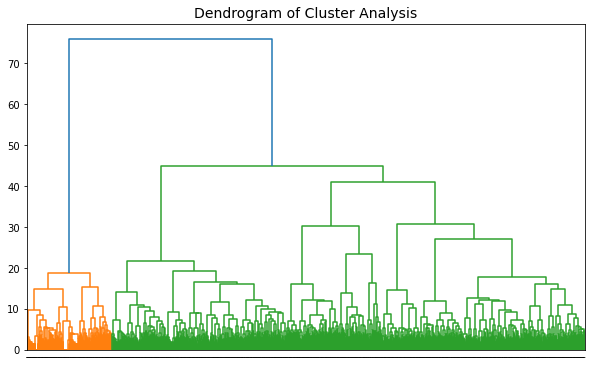

In [188]:
dn = dendrogram(dist)

plt.gcf().set_size_inches(10, 6)

plt.xticks(rotation=0, size=0)
plt.yticks(size=10)

plt.title("Dendrogram of Cluster Analysis", size=14)
plt.show()

In [138]:
company_profile['cluster'] = pd.Series(fcluster(dist, t=5, criterion = 'maxclust'))

In [160]:
company_profile.dropna(subset = ['cluster'], inplace=True)
# company_profile.to_csv('company_cluster.csv')

company_profile.head()

,H1B,profile,Name,Inactive,Quoted,Branch,OwnData,Woco,Revenue,Employee,...,Type,Date of incorporation,City,State,NAICS_code,Emp_cat,Rev_cat,Age,Age_cat,cluster
0,1 Way Solutions,1 WAY SOLUTIONS INC,1 WAY SOLUTIONS INC,False,False,False,False,False,4470,22,...,Corporate,2005-01-01,MARIETTA,GA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",15,"(13.9, 20.16]",5.0
1,1052 Partners,1052 PARTNERS LLC,1052 PARTNERS LLC,False,False,False,False,False,150,1,...,Corporate,2100-01-01,CHICAGO,IL,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",-80,unknown,2.0
2,110 Holdings,110 HOLDINGS LLC,110 HOLDINGS LLC,False,False,False,False,False,470,1,...,Corporate,2011-01-01,BELLEVUE,WA,55,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",9,"(7.64, 13.9]",2.0
3,12Th Wonder,12TH WONDER LLC,12TH WONDER LLC,False,False,False,False,False,490,2,...,Corporate,2012-01-01,PLEASANTON,CA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",8,"(7.64, 13.9]",2.0
4,14 W Administrative Services,14W ADMINISTRATIVE SERVICES LLC,14W ADMINISTRATIVE SERVICES LLC,False,False,False,False,False,35400,295,...,Corporate,1988-01-01,BALTIMORE,MD,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",32,"(26.42, 32.68]",5.0


#  Examine Clustering Results

With the clustering results, now that I can see how each of the groups are hiring, in terms of the number of people hired, the difference in salary and industry, etc.

In [6]:
data = pd.read_csv('company_cluster.csv', usecols=list(range(1, 24)), dtype={'cluster': 'Int64'})
data['cluster'] = data['cluster'].astype(str)
data['Size'] = pd.Categorical(data['Size'], 
                                 categories=['Small company', 'Medium sized company',
                                           'Large company', 'Very large company'],
                                 ordered=True)
data = data[data['cluster'] != '<NA>']

data.head()

,H1B,profile,Name,Inactive,Quoted,Branch,OwnData,Woco,Revenue,Employee,...,Type,Date of incorporation,City,State,NAICS_code,Emp_cat,Rev_cat,Age,Age_cat,cluster
0,1 Way Solutions,1 WAY SOLUTIONS INC,1 WAY SOLUTIONS INC,False,False,False,False,False,4470.0,22.0,...,Corporate,2005-01-01,MARIETTA,GA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",15,"(13.9, 20.16]",5
1,1052 Partners,1052 PARTNERS LLC,1052 PARTNERS LLC,False,False,False,False,False,150.0,1.0,...,Corporate,2100-01-01,CHICAGO,IL,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",-80,unknown,2
2,110 Holdings,110 HOLDINGS LLC,110 HOLDINGS LLC,False,False,False,False,False,470.0,1.0,...,Corporate,2011-01-01,BELLEVUE,WA,55,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",9,"(7.64, 13.9]",2
3,12Th Wonder,12TH WONDER LLC,12TH WONDER LLC,False,False,False,False,False,490.0,2.0,...,Corporate,2012-01-01,PLEASANTON,CA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",8,"(7.64, 13.9]",2
4,14 W Administrative Services,14W ADMINISTRATIVE SERVICES LLC,14W ADMINISTRATIVE SERVICES LLC,False,False,False,False,False,35400.0,295.0,...,Corporate,1988-01-01,BALTIMORE,MD,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",32,"(26.42, 32.68]",5


### How many companies are there in each cluster?

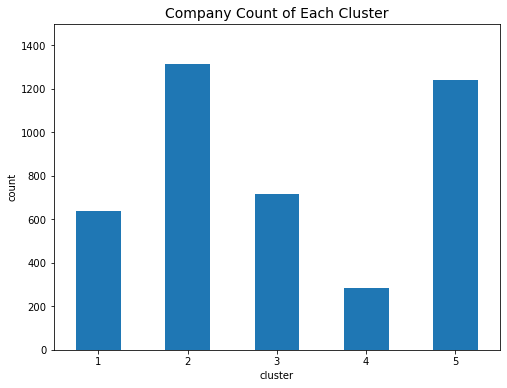

In [4]:
pd.DataFrame(data.groupby(['cluster']).size()).plot(kind='bar')
plt.gcf().set_size_inches(8, 6)
plt.gca().get_legend().remove()

plt.xticks(rotation=0, size=10)
plt.yticks(size=10)

plt.xlabel('cluster', size=10)
plt.ylabel('count', size=10)

plt.ylim(0, 1500)

plt.title("Company Count of Each Cluster", size=14)
plt.show()

### What is the size of the company for each cluster?

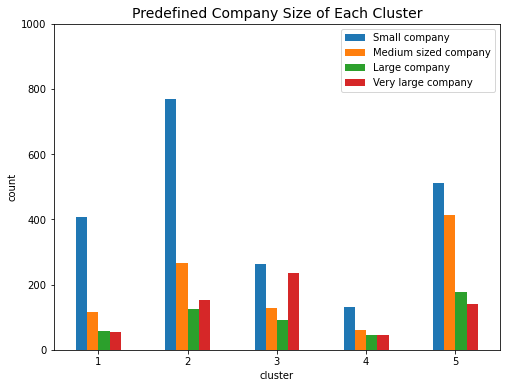

In [5]:
pd.DataFrame(data.groupby(['cluster', 'Size']).size()).unstack()[0].dropna().plot(kind='bar')
plt.gcf().set_size_inches(8, 6)
plt.legend(title='', loc=0)

plt.xticks(rotation=0, size=10)
plt.yticks(size=10)

plt.xlabel('cluster', size=10)
plt.ylabel('count', size=10)

plt.ylim(0, 1000)

plt.title("Predefined Company Size of Each Cluster", size=14)
plt.show()

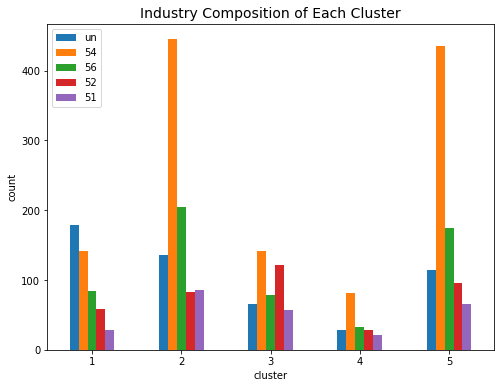

In [6]:
industry = pd.DataFrame(data.groupby(['cluster', 'NAICS_code']).size()).unstack()[0].fillna(0)
industry = industry.T.sort_values(by=['1', '2', '3', '4', '5'], ascending=False).T
industry.iloc[:, :5].plot(kind = 'bar')

plt.gcf().set_size_inches(8, 6)
plt.legend(title='', loc=0)

plt.xticks(rotation=0, size=10)
plt.yticks(size=10)

plt.xlabel('cluster', size=10)
plt.ylabel('count', size=10)

#plt.ylim(0, 1000)

plt.title("Industry Composition of Each Cluster", size=14)
plt.show()

In [12]:
# Mean and median revenue of each cluster
data.groupby(['cluster'])['Revenue'].agg(['median', 'mean']).rename(columns={'median': 'revenue_median', 'mean': 'revenue_mean'})
#data.groupby(['cluster'])['Revenue'].quantile(0.75)

,revenue_median,revenue_mean
cluster,,
1,1538.5,1.653051e+06
2,675.0,1.003204e+06
3,7749.0,2.700315e+06
4,1630.0,4.543758e+05
5,2220.0,5.234298e+05


In [13]:
# Mean and median number of employee of each cluster
data.groupby(['cluster'])['Employee'].agg(['median', 'mean']).rename(columns={'median': 'employee_median', 'mean': 'employee_mean'})
#data.groupby(['cluster'])['Employee'].quantile(0.75)

,employee_median,employee_mean
cluster,,
1,8.0,3344.484029
2,4.0,1821.752622
3,36.5,4900.319728
4,12.0,935.680498
5,15.0,1054.364060


In [17]:
# Mean and median ageof each cluster
data.groupby(['cluster'])['Age'].agg(['median']).rename(columns={'median': 'age_median'})
# data.groupby(['cluster'])['Age'].quantile(0.75)

,age_median
cluster,
1,7
2,9
3,13
4,11
5,12


## How about Position Salary for each cluster?

In [83]:
# read H1B position data
df= pd.read_csv('H1B_info.csv', index_col=0)
df['start_date'] = pd.to_datetime(df['start_date'])
df['submit_date'] = pd.to_datetime(df['submit_date'])

data = data[data['cluster'] != '<NA>']

df.head()

,name,title,base_salary,submit_date,start_date,status,city,state,small_company
0,Emritsolutions,Analyst,49340,2019-06-19,2019-07-01,Certified,Warsaw,Indiana,True
1,Mergermarket (Us),Analyst,52740,2020-04-15,2020-09-01,Certified,New York,New York,False
2,Mergermarket (Us),Analyst,52740,2020-05-01,2020-09-01,Certified,New York,New York,False
3,Altfest Personal Wealth Management,Analyst,53000,2018-03-12,2018-09-11,Certified,New York,New York,False
4,Rizontek,Analyst,54000,2020-05-06,2020-10-01,Certified,Austin,Texas,False


In [84]:
# read company profile and cluster result
data = pd.read_csv('company_cluster.csv', usecols=list(range(1, 24)), dtype={'cluster': 'Int64'})
data['cluster'] = data['cluster'].astype(str)
data['Size'] = pd.Categorical(data['Size'], 
                                 categories=['Small company', 'Medium sized company',
                                           'Large company', 'Very large company'],
                                 ordered=True)
data.head()

,H1B,profile,Name,Inactive,Quoted,Branch,OwnData,Woco,Revenue,Employee,...,Type,Date of incorporation,City,State,NAICS_code,Emp_cat,Rev_cat,Age,Age_cat,cluster
0,1 Way Solutions,1 WAY SOLUTIONS INC,1 WAY SOLUTIONS INC,False,False,False,False,False,4470.0,22.0,...,Corporate,2005-01-01,MARIETTA,GA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",15,"(13.9, 20.16]",5
1,1052 Partners,1052 PARTNERS LLC,1052 PARTNERS LLC,False,False,False,False,False,150.0,1.0,...,Corporate,2100-01-01,CHICAGO,IL,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",-80,unknown,2
2,110 Holdings,110 HOLDINGS LLC,110 HOLDINGS LLC,False,False,False,False,False,470.0,1.0,...,Corporate,2011-01-01,BELLEVUE,WA,55,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",9,"(7.64, 13.9]",2
3,12Th Wonder,12TH WONDER LLC,12TH WONDER LLC,False,False,False,False,False,490.0,2.0,...,Corporate,2012-01-01,PLEASANTON,CA,54,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",8,"(7.64, 13.9]",2
4,14 W Administrative Services,14W ADMINISTRATIVE SERVICES LLC,14W ADMINISTRATIVE SERVICES LLC,False,False,False,False,False,35400.0,295.0,...,Corporate,1988-01-01,BALTIMORE,MD,56,"(-351.599, 7052.98]","(-285061.536, 5479974.72]",32,"(26.42, 32.68]",5


In [85]:
df =  df.merge(data, left_on='name', right_on='H1B')[['Name', 'title', 'base_salary', 'start_date',
                                              'city', 'state', 'City', 'State', 'NAICS_code', 'cluster']]
df.rename(columns = {'city': 'pos_city',
                                           'state': 'pos_state',
                                           'City': 'com_city',
                                           'State': 'com_state'}, inplace=True)

df.head()

,Name,title,base_salary,start_date,pos_city,pos_state,com_city,com_state,NAICS_code,cluster
0,ALTFEST PERSONAL WEALTH MANAGEMENT,Analyst,53000,2018-09-11,New York,New York,NEW YORK,NY,52,3
1,ALTFEST PERSONAL WEALTH MANAGEMENT,Analyst,66000,2018-09-11,New York,New York,NEW YORK,NY,52,3
2,ALTFEST PERSONAL WEALTH MANAGEMENT,Analyst,67500,2019-09-07,New York,New York,NEW YORK,NY,52,3
3,ALTFEST PERSONAL WEALTH MANAGEMENT,Analyst,67500,2019-09-14,New York,New York,NEW YORK,NY,52,3
4,ALTFEST PERSONAL WEALTH MANAGEMENT,Analyst,67500,2018-11-01,New York,New York,NEW YORK,NY,52,3


### Which title/cluster combination makes the most?

In [93]:
df.groupby(['cluster', 'title'])['base_salary'].agg(['median', 'mean', 'size']).reset_index().sort_values(by='median', ascending=False).head(10)

,cluster,title,median,mean,size
18,2,Data Scientist 1,142000.0,138551.157895,19
49,5,Data Scientist 1,140000.0,133605.617647,34
20,2,Data Scientist I,112250.0,111046.993506,154
51,5,Data Scientist I,110000.0,103857.000000,31
8,1,Data Scientist Analyst,105000.0,100648.888889,9
7,1,Data Scientist 1,99060.0,102686.666667,6
31,3,Data Scientist I,98925.0,93194.071429,28
16,2,Business Intelligence Engineer,97569.0,103137.562500,48
47,5,Business Intelligence Engineer,96700.0,103758.600000,35
50,5,Data Scientist Analyst,96250.0,100470.900000,10


### What industry/cluster makes the most?

In [91]:
df.groupby(['cluster', 'NAICS_code'])['base_salary'].agg(['median', 'mean', 'size']).reset_index().sort_values(by='median', ascending=False).head(10)

,cluster,NAICS_code,median,mean,size
77,4,31,125965.0,113310.000000,3
74,4,11,120000.0,120000.000000,1
84,4,49,120000.0,120000.000000,1
45,2,72,116495.0,108407.928571,14
4,1,32,112350.0,99633.833333,6
10,1,49,110000.0,110031.333333,3
33,2,45,108000.0,101594.717842,241
94,4,72,105740.0,100679.333333,3
109,5,52,100000.0,95429.483159,861
11,1,51,94653.5,96384.703704,108


### Which State/City of the position is pays more?

In [94]:
df.groupby(['cluster', 'pos_state', 'pos_city'])['base_salary'].agg(['median', 'mean', 'size']).reset_index().sort_values(by='median', ascending=False).head(10)

,cluster,pos_state,pos_city,median,mean,size
91,1,Connecticut,Greenwich,200000.0,198000.000000,5
1301,3,California,Union City,175000.0,175000.000000,1
831,2,Michigan,Wayne,166400.0,166400.000000,1
1728,4,California,Menlo Park,165000.0,165000.000000,1
23,1,California,East Palo Alto,151000.0,151000.000000,2
493,2,California,East Palo Alto,145000.0,140500.000000,4
1897,4,Texas,Frisco,141450.0,141450.000000,1
1831,4,New Jersey,Jersey City,140000.0,128536.000000,5
1788,4,Maryland,Gwynn Oak,140000.0,140000.000000,3
489,2,California,Cupertino,139420.0,117946.666667,3


### Which cluster hires most DS people?

In [77]:
pd.DataFrame(df.groupby(['cluster', 'Name']).size()).reset_index().rename(columns={0:"count"}).sort_values(by='count', ascending=False).groupby('cluster').mean()
pd.DataFrame(df.groupby(['cluster', 'Name']).size()).reset_index().rename(columns={0:"count"}).sort_values(by='count', ascending=False).head(10)

,cluster,Name,count
3947,5,TATA CONSULTANCY SERVICES LTD,3218
3212,5,DELOITTE CONSULTING LLP,1888
2208,3,"GOLDMAN, SACHS & CO LLC",972
3053,5,"BLACKROCK FINANCIAL MANAGEMENT, INC.",658
3351,5,"GOLDMAN, SACHS & CO LLC",547
525,1,TECH MAHINDRA AMERICAS INC,281
644,2,ACCENTURE LLP,242
2340,3,MORGAN STANLEY SERVICES GROUP INC.,221
3146,5,COMPUNNEL SOFTWARE GROUP INC,202
3464,5,JPMORGAN CHASE & CO,164


In [27]:
pd.DataFrame(df.groupby(['cluster', 'title']).size()).rename(columns={0:"count"}).reset_index().sort_values(by='count', ascending=False)

,cluster,title,count
42,5,Analyst,6864
12,2,Business Analyst,2533
43,5,Business Analyst,1862
22,3,Analyst,1776
1,1,Business Analyst,1099
17,2,Data Analyst,1047
48,5,Data Analyst,905
23,3,Business Analyst,812
14,2,Business Intelligence Analyst,536
28,3,Data Analyst,467
